<a href="https://colab.research.google.com/github/AlvarFeher/TFG/blob/main/Copia_de_Ntuple_para_photon_ID_en_el_Upgrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Resumen Miriam
Resumidamente, el dataset contiene los Digits, o depósitos de energía en cada celda de ECAL, y por otro lado, las MC particles que realmente había en el 'suceso' y qué energía depositaban en cada celda de ECAL. Creo que si nos restringimos a los fotones (MCID = 22), que depositan toda su energía en ECAL, y comparamos su energía real (MCP) con lo que se deposita en ECAL (suma de los digitE para las 3x3 celdas - o lo que consideremos óptimo - alrededor de la celda donde deposite su máxima energía), ya podremos obtener algún primer resultado. Habrá que comprobar que no haya otras partículas que contribuyan significativamente con depósitos de energía en esas mismas celdas, etc.

In [ ]:
import copy # copy variables
import os   # manage paths
import pandas as pd
!!pip3 install jupyterlab matplotlib tqdm uproot==5.1.2 awkward==2.5.0 vector==1.1.1 zstandard
import uproot   # use of root files
import awkward as ak
import vector
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
!pip install awkward-pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filename = "/content/drive/MyDrive/TFG/data/MCKstgamma_Sim10Up06_RecoUp03.root"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file = uproot.open(filename)

print('TTree objects inside the ROOT file:')
for key in file.keys():
    print('-', key)

TTree objects inside the ROOT file:
- AlePhotons;1
- AlePhotons/photonUpgrade;2
- AlePhotons/photonUpgrade;1


In [ ]:

tree_path = "AlePhotons/photonUpgrade"
# Load the tree into a pandas DataFrame
with uproot.open(filename) as file:
    tree = file[tree_path]
    rootdf = tree.arrays(library="pd")  # Convert ROOT tree to pandas DataFrame

print(rootdf.head(2))

   evtnum  MCparts  recible  signal    pz  pt200   ir    ND  \
0  303626    10619     1108    1108   960    879  390  2963   
1  303627    13328     1264    1264  1003    928  481  3283   

                                              digitX  \
0  [-3596.050048828125, -3474.14990234375, -3352....   
1  [-3717.949951171875, -3596.050048828125, -3474...   

                                              digitY  ...  \
0  [-2377.224609375, -2377.224609375, -2377.22460...  ...   
1  [-2864.821533203125, -2864.821533203125, -2864...  ...   

                                               MCDVy  \
0  [-149.64120483398438, 1327.591064453125, 601.7...   
1  [112.3093032836914, -16.58609962463379, 1131.7...   

                                               MCDVz  \
0  [12161.0458984375, 13525.1025390625, 7842.7797...   
1  [8578.728515625, 2916.91552734375, 12607.75097...   

                                            MCdigitE  \
0  [[830.9498901367188, 441.88470458984375, 371.4...   
1  [[17

Remove columns

In [ ]:
cols_to_remove = ['MCparts', 'recible', 'signal', 'pz', 'pt200', 'ir', 'NP', 'ND']

rootdf.drop(columns=cols_to_remove, inplace=True, errors='ignore')  # Ignore errors if some columns don't exist

# print(rootdf.head())

Divide the dataset into chunks

In [ ]:
import pickle

# Filter the DataFrame to include only relevant columns
columns_to_keep = ['evtnum', 'digitE', 'digitR', 'digitC', 'MCID', 'MCP']
filtered_df = rootdf[columns_to_keep]

# Save the filtered DataFrame as a pickle file
with open('filtered_data.pkl', 'wb') as file:
    pickle.dump(filtered_df, file)

print("Filtered data saved to 'filtered_data.pkl'")


Filtered data saved to 'filtered_data.pkl'


In [ ]:
import pandas as pd
import pickle

# Cargar el dataset desde el pickle
with open('filtered_data.pkl', 'rb') as file:
    filtered_df = pickle.load(file)

# Asegurarse de que las columnas sean listas
filtered_df['digitE'] = filtered_df['digitE'].apply(lambda x: x if isinstance(x, list) else list(x))
filtered_df['digitR'] = filtered_df['digitR'].apply(lambda x: x if isinstance(x, list) else list(x))
filtered_df['digitC'] = filtered_df['digitC'].apply(lambda x: x if isinstance(x, list) else list(x))
filtered_df['MCID'] = filtered_df['MCID'].apply(lambda x: x if isinstance(x, list) else list(x))
filtered_df['MCP'] = filtered_df['MCP'].apply(lambda x: x if isinstance(x, list) else list(x))

# Filtrar fotones (MCID == 22)
photons = filtered_df[filtered_df['MCID'].apply(lambda x: 22 in x)].copy()

# Seleccionar el fotón de interés
photon_of_interest = photons.iloc[0]
photon_energy = photon_of_interest['MCP'][0]
photon_position = (photon_of_interest['digitR'][0], photon_of_interest['digitC'][0])

# Localizar fotones vecinos
neighbor_threshold = 5  # Define el máximo umbral de distancia para considerar vecinos
neighbors = []

for _, photon in photons.iterrows():
    if len(photon['digitE']) > 0 and len(photon['digitR']) > 0 and len(photon['digitC']) > 0:
        neighbor_position = (photon['digitR'][0], photon['digitC'][0])
        distance = abs(photon_position[0] - neighbor_position[0]) + abs(photon_position[1] - neighbor_position[1])
        if distance <= neighbor_threshold and photon.name != photon_of_interest.name:
            neighbors.append({
                'ID': photon.name,
                'Energy': photon['MCP'][0],
                'Position': neighbor_position,
                'Distance': distance
            })

# Crear un DataFrame para los vecinos
neighbors_df = pd.DataFrame(neighbors)


In [ ]:
if not neighbors_df.empty:
    # Ordenar por distancia para facilitar la interpretación
    neighbors_df = neighbors_df.sort_values(by='Distance').reset_index(drop=True)

    # Mostrar la tabla
    print("\nTabla de Vecinos del Fotón de Interés:")
    print(neighbors_df.to_markdown(index=False))  # Mostrar como tabla en consola
else:
    print("No se encontraron vecinos para el fotón de interés.")


Tabla de Vecinos del Fotón de Interés:
|   ID |     Energy | Position    |   Distance |
|-----:|-----------:|:------------|-----------:|
| 2236 |   4.15693  | (12.0, 2.0) |          0 |
| 1514 |   3.29677  | (12.0, 2.0) |          0 |
| 2944 |  13.8512   | (12.0, 2.0) |          0 |
|  498 |   6.46079  | (12.0, 2.0) |          0 |
| 2711 |  11.5537   | (12.0, 2.0) |          0 |
| 1705 |   1.40634  | (12.0, 2.0) |          0 |
| 1954 |   8.42022  | (12.0, 2.0) |          0 |
| 2408 |  26.4671   | (12.0, 2.0) |          0 |
| 3450 |  11.9696   | (12.0, 2.0) |          0 |
|  466 |  30.3937   | (12.0, 2.0) |          0 |
| 3117 |   1.19329  | (12.0, 2.0) |          0 |
|  587 |  22.7916   | (12.0, 2.0) |          0 |
| 1249 |   1.77385  | (12.0, 2.0) |          0 |
| 1615 |   7.42302  | (12.0, 2.0) |          0 |
| 1526 |  11.0655   | (12.0, 2.0) |          0 |
| 1648 |   9.84521  | (11.0, 2.0) |          1 |
| 1251 |  17.7459   | (12.0, 1.0) |          1 |
| 1999 |  18.707    | (13.0, 

Store data as Json

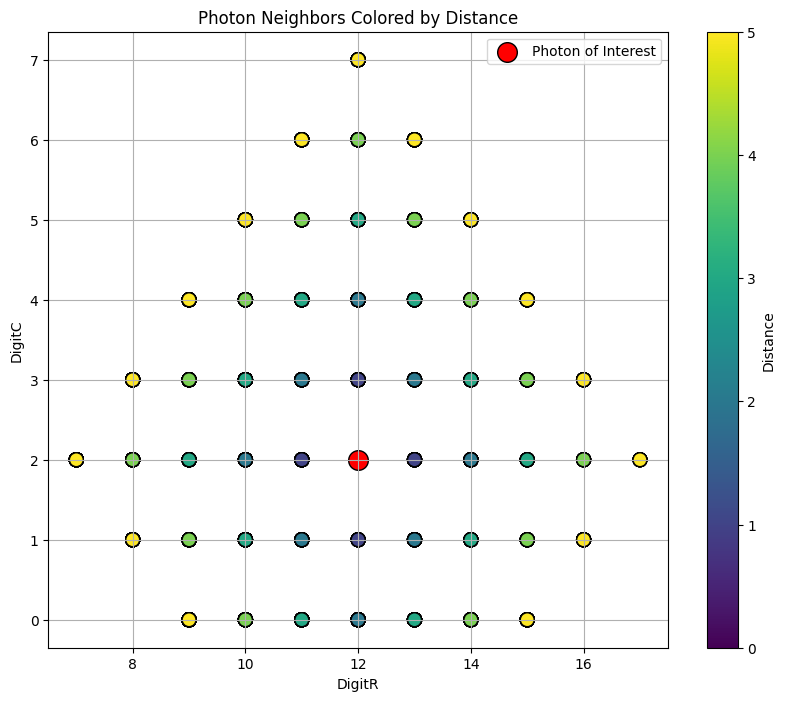

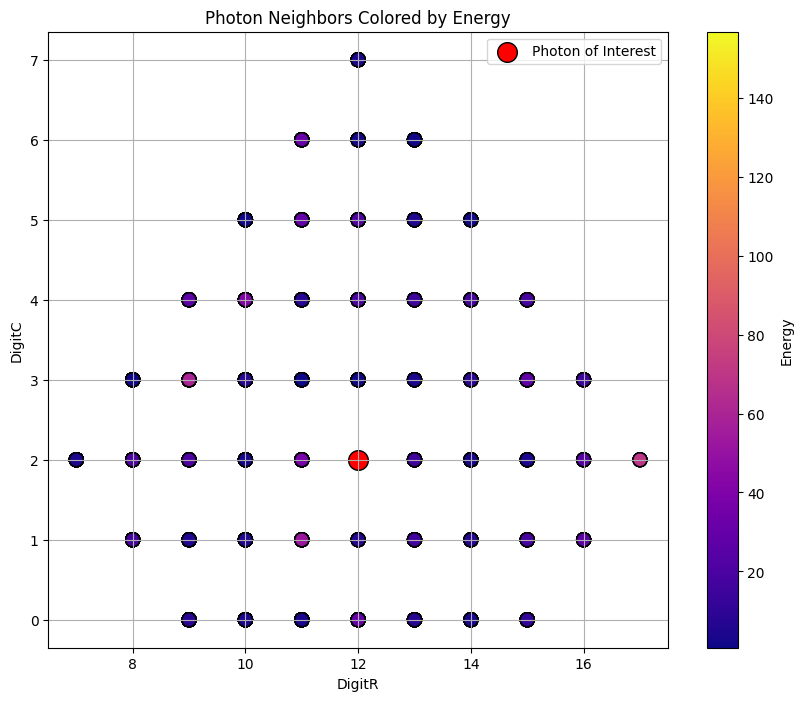

In [ ]:
if not neighbors_df.empty:
    # Ordenar por distancia para facilitar la interpretación
    neighbors_df = neighbors_df.sort_values(by='Distance').reset_index(drop=True)

    # Extraer datos para el gráfico
    x_positions = [pos[0] for pos in neighbors_df['Position']]
    y_positions = [pos[1] for pos in neighbors_df['Position']]
    distances = neighbors_df['Distance']
    energies = neighbors_df['Energy']

    # 1. Gráfico con colores según la distancia
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        x_positions, y_positions, c=distances, cmap='viridis', s=100, edgecolor='k'
    )
    plt.colorbar(scatter, label="Distance")
    plt.scatter(photon_position[0], photon_position[1], color='red', s=200, label="Photon of Interest", edgecolor='k')
    plt.title("Photon Neighbors Colored by Distance")
    plt.xlabel("DigitR")
    plt.ylabel("DigitC")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Gráfico con colores según la energía
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        x_positions, y_positions, c=energies, cmap='plasma', s=100, edgecolor='k'
    )
    plt.colorbar(scatter, label="Energy")
    plt.scatter(photon_position[0], photon_position[1], color='red', s=200, label="Photon of Interest", edgecolor='k')
    plt.title("Photon Neighbors Colored by Energy")
    plt.xlabel("DigitR")
    plt.ylabel("DigitC")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No se encontraron vecinos para el fotón de interés.")